# Pràctica 2 Tipologia i cicle de vida de les dades

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy.stats import shapiro, fligner, pearsonr, spearmanr, mannwhitneyu, chi2_contingency, chi2, norm
warnings.filterwarnings('ignore')

## 1. Load data

In [2]:
# Read csv
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')

# dataframes size
print(f"Train dataframe: {str(len(data_train))} rows and {str(len(data_train.columns))} columns")
print(f"Test dataframe: {str(len(data_test))} rows and {str(len(data_test.columns))} columns")

Train dataframe: 891 rows and 12 columns
Test dataframe: 418 rows and 11 columns


In [3]:
print(f"Test columns: {list(data_test.columns)}") # We want to predict "Survived"
data_train.head(2)

Test columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Since the test dataset doesn't has the "Survived" variable, we are going to predict if the passangers survived using the information contained in the other columns.

## 2. Data Integration

The columns "PassengerId", "Name" and "Ticket" are going to be droped of the dataset because they will not provide relevant information to a possible clasificator.

In [4]:
df = data_train.drop(["PassengerId", "Name", "Ticket"], axis=1)
df_test = data_test.drop(["PassengerId", "Name", "Ticket"], axis=1)

## 3. Data cleansing
### 3.1 Missing values

The normalization will be performed in data already splitted in training and test. Thus, we are going to focus on the training set and later we will apply the same normalization procedures on the test set. 

In [5]:
# Train
def find_missing_values(dataset_name, df):
    """
    Find number of NaN per variable and computes their the percentage of NaN values.
    """
    print(f"{dataset_name} missing values:")
    nulls = df.isnull().sum()
    percent_nulls = round(nulls / df.shape[0]*100,2)
    zipped = list(zip(df.columns, nulls, percent_nulls))
    df_nulls = pd.DataFrame(zipped, columns=["Variable", "NaN", "Percent"]).set_index("Variable")
    df_nulls.sort_values("NaN", ascending=False, inplace=True)
    return df_nulls

In [6]:
find_missing_values("Training", df)

Training missing values:


,NaN,Percent
Variable,,
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Survived,0,0.00
Pclass,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Fare,0,0.00


Since "Cabin" variable is missing in 77% of the observations we are going to drop this column. Variables "Age" and "Embarked" have 20% and 0.2% of missing values. Since they don't have a majority of missing values we are going to replace them.

In [7]:
### Cabin ###
df.drop(["Cabin"], axis=1, inplace=True)

Before replacing "Age" missing values, we are going to check the quality of two possible imputations comparing them with the real values in the train dataset. The first one is using the median of the observations within the same group considering the variables "Pclass", "Sex" and "Parch" and the second one using the mean.

In [8]:
### Age ###

age_testing = df[df['Age'].notnull()]
age_testing['Age_median'] = 0
age_testing['Age_mean'] = 0

# Median values of reference
print("------Median-------")
group = age_testing.groupby(['Pclass', 'Sex', 'Parch'])['Age'].median().reset_index()
for i, row in group.iterrows():
    for u, pasn in age_testing.iterrows():
        if (row[0] == pasn[1]) and (row[1] == pasn[2]) and (row[2] == pasn[5]):
            age_testing.loc[u, 'Age_median'] = group.loc[i, 'Age']

# Difference between real values and median
age_testing['diff_median'] = age_testing['Age'] - age_testing['Age_median']
print(age_testing['diff_median'].describe())
            
    
# Mean values of reference
print("\n\n------Mean-------")
group = age_testing.groupby(['Pclass', 'Sex', 'Parch'])['Age'].mean().reset_index()
for i, row in group.iterrows():
    for u, pasn in age_testing.iterrows():
        if (row[0] == pasn[1]) and (row[1] == pasn[2]) and (row[2] == pasn[5]):
            age_testing.loc[u, 'Age_mean'] = group.loc[i, 'Age']

# Difference between real values and mean
age_testing['diff_mean'] = age_testing['Age'] - age_testing['Age_mean']
print(age_testing['diff_mean'].describe())

------Median-------
count    714.000000
mean       1.968025
std       12.041460
min      -26.500000
25%       -6.000000
50%        0.000000
75%        8.000000
max       48.000000
Name: diff_median, dtype: float64


------Mean-------
count    7.140000e+02
mean     1.696744e-15
std      1.192281e+01
min     -2.450641e+01
25%     -8.295192e+00
50%     -1.723958e+00
75%      6.183333e+00
max      4.518333e+01
Name: diff_mean, dtype: float64


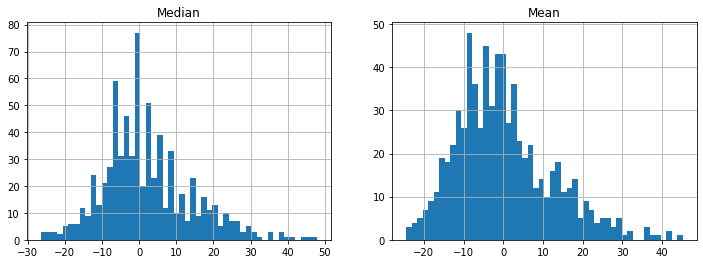

In [9]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
age_testing['diff_median'].hist(bins=50, ax=ax1)
age_testing['diff_mean'].hist(bins=50, ax=ax2)
ax1.set_title("Median")
ax2.set_title("Mean")
plt.show()

As we have proved in the graphics, these methods have a pretty good accuracy. The majority of observations have an error between -10 and 10 years however, the maximum errors reach values of almost-30 and 40 (surely due to the existence of outliers within the groups of "Pclass", "Sex" and "Parch"). 

Even though the mean obtained lower extrem values, we are going to use the median owing to their even higher majority of errors around -10 and 10. Thus, "Age" variable will be replaced by the median (a robust estimator of location) of the observations within the same group considering the variables "Pclass", "Sex" and "Parch". In this way, the missing values will replaced by the median of the travellers with the same economical level, sex and number of parents and/or childrens.

In [10]:
df['Age'] = df.groupby(['Pclass', 'Sex', 'Parch'])['Age'].apply(lambda x: x.fillna(x.median()))

"Embarked" variable only has 2 missing observations, therefore we can correct manually these values. Following kaggle forum suggestions, we can quickly search for passengers information on the Internet:
- https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
- https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

In [11]:
### Embarked ###
data_train.loc[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [12]:
df.loc[df['Embarked'].isnull(), 'Embarked'] = 'S'

Finally we check if there are still any missing value.

In [13]:
find_missing_values("Training", df)

Training missing values:


,NaN,Percent
Variable,,
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


Now we are going to check the test dataset:

In [14]:
find_missing_values("Test", df_test)

Test missing values:


,NaN,Percent
Variable,,
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Pclass,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Embarked,0,0.00


The test dataset has similar numbers of missing values. "Cabin" variable still has more than 70% of missing values and therefore, this column will be removed. Age also has a 20% of missing values that will reeplaced by the median of the observations within the same group of "Pclass", "Sex" and "Patch". Finally, there is 1 missing value in the Fare class that we will explore and try to replace in the next cells.

In [15]:
# Cabin
df_test.drop(["Cabin"], axis=1, inplace=True)

# Age
df_test['Age'] = df.groupby(['Pclass', 'Sex', 'Parch'])['Age'].apply(lambda x: x.fillna(x.median()))

# Fare
data_test.loc[data_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


As we can see in the following url (https://www.encyclopedia-titanica.org/titanic-victim/thomas-storey.html), in this case there is no information about the fare. Thus, we are going to replace the missing value by the median of other passengers information.

In [16]:
fare = df[(df['Pclass'] == 3) & (df['SibSp'] == 0) & 
          (df['Parch'] == 0) & (df["Embarked"] == "S")]['Fare'] 

df_test.loc[df_test['Fare'].isnull(), 'Fare'] = fare.median()

In [17]:
find_missing_values("Test", df_test)

Test missing values:


,NaN,Percent
Variable,,
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


Now let's check if there are 0 values that could represent missing values:

In [18]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.018148,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.577341,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The variables "Survived", "SibSp", "Parch" and "Fare" have 0 values, however in all of them 0 values have a meaning. In the first one it means that the passenger doesn't survive and in the second and third ones they represent the number of relatives in the Titanic. The last one could be considered as free travels or missing values however (and it is a personal interpretation), I think they could correspond to some of the Titanic crew. To suport my idea, we can see on the following histogram that there are a few number of 0 values in the "Fare" variable that could represent some of the crewstaff.

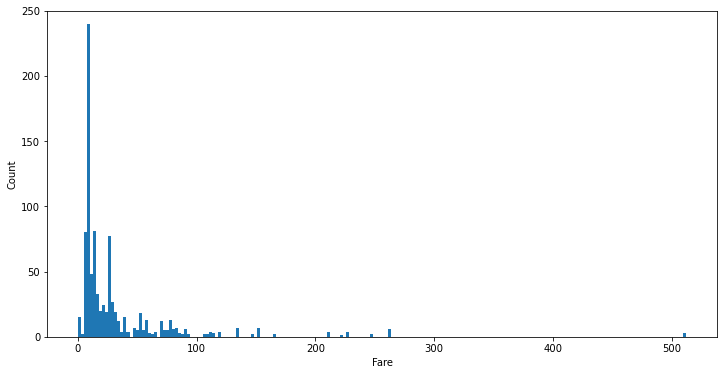

In [19]:
# Fare distribution
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.hist(df['Fare'], bins=200)
ax.set_ylim([0, 250])
plt.ylabel("Count")
plt.xlabel("Fare")
plt.show()

### 3.2 Outliers

              Age        Fare
count  891.000000  891.000000
mean    29.018148   32.204208
std     13.577341   49.693429
min      0.420000    0.000000
25%     21.500000    7.910400
50%     26.000000   14.454200
75%     36.000000   31.000000
max     80.000000  512.329200


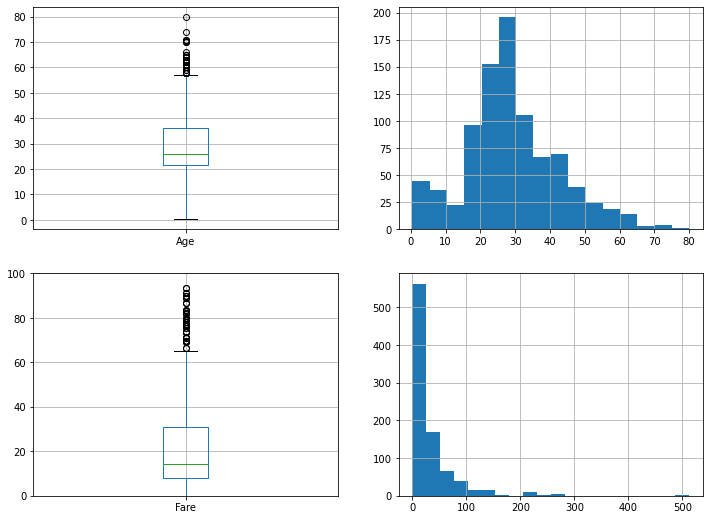

Age variable has 33 outliers considering 1.5*IQR
Fare variable has 116 outliers considering 1.5*IQR


In [20]:
# Age and Fare describe
print(df.loc[:,["Age","Fare"]].describe())

# Boxplots
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(12,9))
df.boxplot(column="Age",ax=ax1[0])
df['Age'].hist(bins=16, ax=ax1[1])
df.boxplot(column="Fare",ax=ax2[0])
df['Fare'].hist(bins=20, ax=ax2[1])
ax2[0].set_ylim([0,100])
plt.show()

# Number of outliers
Q1 = df.loc[:,["Age","Fare"]].quantile(0.25)
Q3 = df.loc[:,["Age","Fare"]].quantile(0.75)
IQR = Q3 - Q1
limit = Q3 + 1.5 * IQR
age_outliers = df.loc[df["Age"] > limit[0], 'Age'].count()
fare_outliers = df.loc[df["Fare"] > limit[1], 'Fare'].count()
print(f"Age variable has {age_outliers} outliers considering 1.5*IQR")
print(f"Fare variable has {fare_outliers} outliers considering 1.5*IQR")      

Variable "Age" is in a range between 0 and 80 years. Although there are 33 outliers we will not consider them as extrem values because they are equal or below 80 years, a perfectly feasible age. On the other hand, "Fare" variable has 166 outliers, some of them with a pretty high values. Let's explore them:

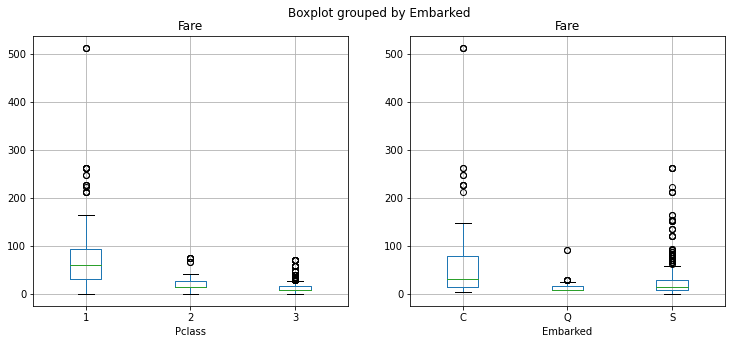

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
df.boxplot(column="Fare", by="Pclass", ax=ax1)
df.boxplot(column="Fare", by="Embarked", ax=ax2)
plt.show()

All possible outliers are found in 1st class passengers who got on board in Cherbourg or Southampton. Since the most expensive tickets are found in the 1st class, it does not seem like an error. In addition, as we can see in the next cell those who paid 500 survived (not like all of those who paid 200) therefore, they could have received special treatment in the disaster, thus it could be a good a idea to keep this information. 

In [22]:
df[df['Fare'] > 200].sort_values('Fare', ascending=False).loc[:,('Survived', 'Fare')]

,Survived,Fare
258,1,512.3292
679,1,512.3292
737,1,512.3292
27,0,263.0000
341,1,263.0000
438,0,263.0000
88,1,263.0000
311,1,262.3750
742,1,262.3750
118,0,247.5208


In [23]:
# Save final dataset
df.to_csv('train_clean.csv')
df_test.to_csv('test_clean.csv')

## 4. Data Analysis

### 4.1.Univariant and multivariant Analysis

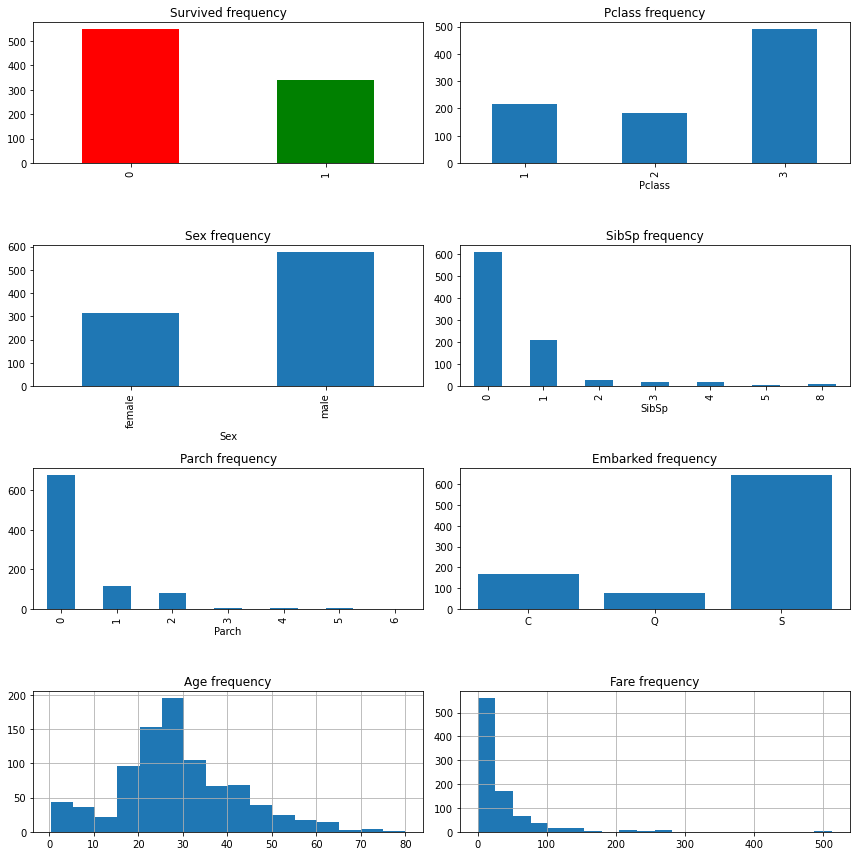

In [24]:
# Univariant analysis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,2, figsize=(12,12))

survived = df.groupby(['Survived']).count().reset_index()['Pclass']
survived.plot.bar(x='Survived', color=['red', 'green'], ax=ax1[0])
ax1[0].set_title('Survived frequency')

pclass = df.groupby(['Pclass']).count()['Survived']
pclass.plot.bar(x='Pclass', ax=ax1[1])
ax1[1].set_title('Pclass frequency')

sex = df.groupby(['Sex']).count()['Survived']
sex.plot.bar(x='Sex', ax=ax2[0])
ax2[0].set_title('Sex frequency')

sib = df.groupby(['SibSp']).count()['Pclass']
sib.plot.bar(x='SibSp', ax=ax2[1])
ax2[1].set_title('SibSp frequency')

parch = df.groupby(['Parch']).count()['Pclass']
parch.plot.bar(x='Parch', ax=ax3[0])
ax3[0].set_title('Parch frequency')

parch = df.groupby(['Embarked']).count().reset_index().loc[:,'Embarked':'Survived']
ax3[1].bar(parch["Embarked"], parch["Survived"])
ax3[1].set_title('Embarked frequency')

df['Age'].hist(bins=16, ax=ax4[0])
ax4[0].set_title('Age frequency')

df['Fare'].hist(bins=20, ax=ax4[1])
ax4[1].set_title('Fare frequency')

plt.tight_layout()

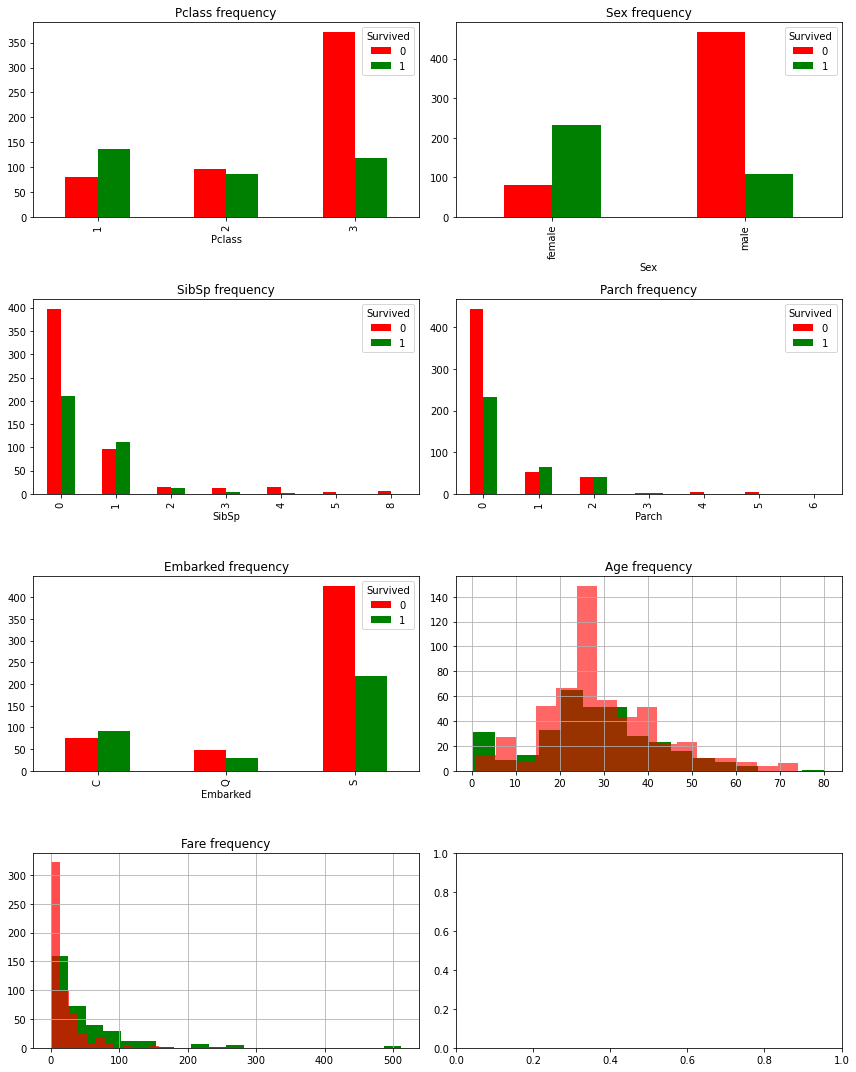

In [25]:
# Multivariant analysis

# Prepare datasets to plot
pclass = df.groupby(['Pclass', 'Survived']).count()['Embarked'].reset_index().pivot(
    index='Pclass', columns='Survived', values="Embarked")

sex = df.groupby(['Sex', 'Survived']).count()['Embarked'].reset_index().pivot(
    index='Sex', columns='Survived', values="Embarked")

sibsp = df.groupby(['SibSp', 'Survived']).count()['Embarked'].reset_index().pivot(
    index='SibSp', columns='Survived', values="Embarked")

parch = df.groupby(['Parch', 'Survived']).count()['Embarked'].reset_index().pivot(
    index='Parch', columns='Survived', values="Embarked")

embarked = df.groupby(['Embarked', 'Survived']).count()['Parch'].reset_index().pivot(
    index='Embarked', columns='Survived', values="Parch")

# Plot 
fg, (ax1, ax2, ax3, ax4) = plt.subplots(4,2, figsize=(12, 15))

pclass.plot.bar(color=['red', 'green'], ax=ax1[0])
sex.plot.bar(color=['red', 'green'], ax=ax1[1])
sibsp.plot.bar(color=['red', 'green'], ax=ax2[0])
parch.plot.bar(color=['red', 'green'], ax=ax2[1])
embarked.plot.bar(color=['red', 'green'], ax=ax3[0])

df[df['Survived'] == 1]['Age'].hist(bins=16, color=['green'], ax=ax3[1], alpha=1)
df[df['Survived'] == 0]['Age'].hist(bins=16, color=['red'], ax=ax3[1], alpha=0.6)

df[df['Survived'] == 1]['Fare'].hist(bins=20, color=['green'], ax=ax4[0], alpha=1)
df[df['Survived'] == 0]['Fare'].hist(bins=20, color=['red'], ax=ax4[0], alpha=0.7)

ax1[0].set_title('Pclass frequency')
ax1[1].set_title('Sex frequency')
ax2[0].set_title('SibSp frequency')
ax2[1].set_title('Parch frequency')
ax3[0].set_title('Embarked frequency')
ax3[1].set_title('Age frequency')
ax4[0].set_title('Fare frequency')

plt.tight_layout()

### 4.2. Data Normality and Homoscedasticity

Normality and homoscedasticity of Age variable:

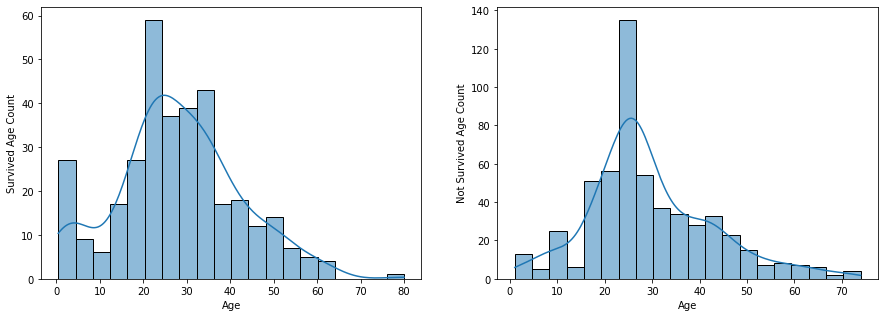

In [26]:
## Age distribution (histogram) of survived and not survived

# Create survived/non_survived DF
survived = df[df["Survived"] == 1]["Age"]
not_survived = df[df["Survived"] == 0]["Age"]

# Plot hists
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(survived, bins = 20, kde = True, ax = axes[0])
axes[0].set_ylabel("Survived Age Count")
sns.histplot(not_survived, bins = 20, kde = True, ax = axes[1])
axes[1].set_ylabel("Not Survived Age Count")
plt.show()

At first sight we could think this are not completely normal distributions. We are going to execute a Shapiro-Wilk test to see if normality reigns over our distribution:

In [27]:
# Shapiro test for Survived DF
print("Survived: ", f'{shapiro(survived)[1]:.2E}')

#Shapiro test for non_survived DF
print("Not Survived: ", f'{shapiro(not_survived)[1]:.2E}')

Survived:  3.34E-04
Not Survived:  1.21E-11


In both cases we obtained a *p-value* less than 0.05, with which we can deny the null hypothesis of normal distributuion in our data (in both populations).

We will now proceed to study the possible homoscedasticity of the variables. As we are not in front of a normal distributed population we are going to apply a Fligner-Killeen test:

In [28]:
# Fligner-Killeen test
print("Fligner-Killeen test: ", f'{fligner(survived, not_survived)[1]:.2E}')

Fligner-Killeen test:  1.15E-02


As we can see, we obtain now a *p-value* less than 0.05, with which we can reject our null hypothesis of homoscedasticity and say that our populations have not equal variances!

### 4.3. Statistical Analysis of Data

Let's focus now between the relationships among our features.

We are going to start with our two numerical variables (_Age_ and _Fare_). To see if they are correlated we are going to calculate Spearman's correlation coefficient (as these are non-normal distributions).

First, though, we are going to see its distribution:

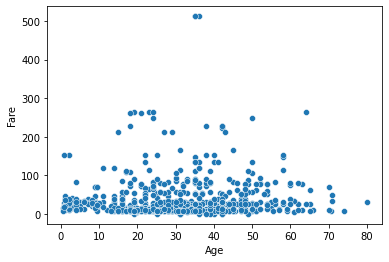

In [29]:
sns.scatterplot(df["Age"], df["Fare"])
plt.show()

As we can see in the scatter plot of this two variables there is not any sign of correlation between them.

Anyway, we are going to calculate both coefficents:

In [30]:
# Spearman
print("Spearman's correlation coefficient: ", round(spearmanr(df["Age"], df["Fare"])[0], 2))

Spearman's correlation coefficient:  0.15


This correlation coefficients confirm what we had already perceived in the plot: the non-correlation between the numeric variables *Fare* and *Age*.

Shall we proceed, then, to see if our survied people ratio keeps relation with the rest of the variables mentioned in 4.1.

We will start, to proceed with age. We are going to see if there are significative statistical between the ages among the two groups. We are going to see that with a Mann-Whitney test (non-parametric because of our non-normality):

In [31]:
## Mann-Whitney test

# We are going to use our DF defined before 'survived' and 'not_survived' that contained
# the ages of the two populations
print(f'p-value: {mannwhitneyu(survived, not_survived)[1]:.2E}')

p-value: 1.50E-01


We can see that we obtained a *p-value* greater than 0.05, with which we fail to reject the null hypothesis that the age distribution among survivors and not-survivors are equal.

We ask ourselves now if this is different when we repeat the hypothesis test but for each gender.

In [32]:
## We separate survived in male and female (and so for not_survived)

male_surv = df.loc[(df["Survived"] == 1) & (df["Sex"] == "male")]["Age"]
male_not_surv = df.loc[(df["Survived"] == 0) & (df["Sex"] == "male")]["Age"]
fem_surv = df.loc[(df["Survived"] == 1) & (df["Sex"] == "female")]["Age"]
fem_not_surv = df.loc[(df["Survived"] == 0) & (df["Sex"] == "female")]["Age"]

# We proceed now to evaluate their normality
print("Male Survived", f'p-value: {shapiro(male_surv)[1]:.2E}')
print("Male Not Survived", f'p-value: {shapiro(male_not_surv)[1]:.2E}')
print("Female Survived", f'p-value: {shapiro(fem_surv)[1]:.2E}')
print("Female Not Survived", f'p-value: {shapiro(fem_not_surv)[1]:.2E}')

Male Survived p-value: 5.98E-03
Male Not Survived p-value: 1.31E-12
Female Survived p-value: 8.28E-04
Female Not Survived p-value: 9.34E-03


We can observe that our data is still not normally distributed.

We proceed to compare the difference between the mean Ages in each sex category:

In [33]:
## Mann-Whitney test

# Male
print("Mann-Whitney test for male population p-value: ",
      f'{mannwhitneyu(male_surv, male_not_surv)[1]:.2E}')

#Female
print("Mann-Whitney test for female population p-value: ",
      f'{mannwhitneyu(fem_surv, fem_not_surv)[1]:.2E}')

Mann-Whitney test for male population p-value:  1.77E-01
Mann-Whitney test for female population p-value:  1.02E-03


As we can see from the results, we fail to reject the null hypothesisi that there is no significant difference in Age distribution between our female population, but we see there is strong evidence against the null hypothesis within the male population.

We conclude then that there is no Age difference between women, but it does exist among men.

We are going to calculate our Confidence Intervals by finding the 2.5% and 97.5% percentiles:

In [34]:
print("Male Survived CI: [", round(np.percentile(male_surv, 2.5),2), ", ",
      round(np.percentile(male_surv, 97.5),2), "]\nMale Survived mean: ", round(np.mean(male_surv),2), "\n")

print("Male Non-Survived CI: [", round(np.percentile(male_not_surv, 2.5),2), ", ",
      round(np.percentile(male_not_surv, 97.5),2), "]\nMale Non-Survived mean: ", round(np.mean(male_not_surv),2), "\n")

print("Female Survived CI: [", round(np.percentile(fem_surv, 2.5),2), ", ",
      round(np.percentile(fem_surv, 97.5),2), "]\nFemale Survived mean: ", round(np.mean(fem_surv),2), "\n")

print("Female Non-Survived CI: [", np.percentile(fem_not_surv, 2.5), ", ",
      round(np.percentile(fem_not_surv, 97.5),2), "]\nFemale Non-Survived mean: ", round(np.mean(fem_not_surv),2), "\n")

Male Survived CI: [ 0.83 ,  57.2 ]
Male Survived mean:  27.69 

Male Non-Survived CI: [ 9.0 ,  62.65 ]
Male Non-Survived mean:  30.74 

Female Survived CI: [ 2.8 ,  58.0 ]
Female Survived mean:  28.28 

Female Non-Survived CI: [ 2.0 ,  48.0 ]
Female Non-Survived mean:  23.0 



Now we are going to study the relationships between the survival and our categorical variables.

We will start with, given the last results about gender, if there is a significant difference in the survival probability between genders. To do so, we are going use a *Chi-Squared Test* as we are dealing with two categorical variables:

In [35]:
## Chi-Squared

# First we have to create our contingency table
contingency_gender = pd.crosstab(df["Survived"], df["Sex"])
print("The contingency table for the Chi-Squared test is: \n\n", contingency_gender, "\n")

# Chi-Sq test
stat, p, dof, expected = chi2_contingency(contingency_gender)

# Critical. We define our confidence level first
conf_lev = 0.95
print("Chi-Squared results:")
print("Statistic, p-value: ", round(stat,2), f'{p:.2E}')
print("Critical: ", round(chi2.ppf(conf_lev, dof),2))

The contingency table for the Chi-Squared test is: 

 Sex       female  male
Survived              
0             81   468
1            233   109 

Chi-Squared results:
Statistic, p-value:  260.72 1.20E-58
Critical:  3.84


As we can see when comparing our statistic with our critical value (`abs(statistic) > critical`) we conclude the same we would conclude when we observe the *p-value* (`p-value < 0.05`): we can reject the null hypothesis that *Survived* and *Sex* are dependent.

Before we continue, we are going to calculate our Confidence Interval:

In [36]:
## Function definition 
def standard_error(p1, p2, n1, n2):
    SE = np.sqrt( (p1 * (1 - p1)/n1) + (p2 * (1 - p2)/n2) )
    return SE

# Male SE
male_p_no = (468)/(468+81)
male_p_yes = (109/(109+233))
n_no = 468+81
n_yes = 109+233

male_SE = standard_error(male_p_yes, male_p_no, n_yes, n_no)
# print("SE:", male_SE)

##Confidence Interval
male_CI = 1.96 * male_SE
# print("CI: ", male_CI)

In [37]:
print("Male Confidence Interval is: [", round(male_p_yes-male_p_no-male_CI, 2), ", ", round(male_p_yes-male_p_no+male_CI, 2) , "],"\
     "\nProportions differnece = ", round(male_p_yes-male_p_no,2))

Male Confidence Interval is: [ -0.59 ,  -0.48 ],
Proportions differnece =  -0.53


In [38]:
##FEMALE CI

# Female SE
fem_p_no = 81/(81+468)
fem_p_yes = 233/(233+109)
n_no = 81+468
n_yes = 233+109

fem_SE = standard_error(fem_p_yes, fem_p_no, n_yes, n_no)
# print("SE: ", fem_SE)

# CI
fem_CI = 1.96 * fem_SE
# print("CI: ", fem_CI)

print("Female Confidence Interval is: [", round(fem_p_yes-fem_p_no-fem_CI,2), ", ", round(fem_p_yes-fem_p_no+fem_CI,2), "]",\
     "\nProportions difference  =", round(fem_p_yes-fem_p_no,2))

Female Confidence Interval is: [ 0.48 ,  0.59 ] 
Proportions difference  = 0.53


In [39]:
## Chi-Squared test for 'pclass' feature

# We create our contingency table
contingency_class = pd.crosstab(df["Survived"], df["Pclass"])
print("The contingency table for the Chi-Squared test is: \n\n", contingency_class, "\n")

# Chi-Sq test
stat, p, dof, expected = chi2_contingency(contingency_class)

# Critical. We define our confidence level first
conf_lev = 0.95
print("Chi-Squared results:")
print("Statistic, p-value: ", round(stat,2) , f'{p:.2E}')
print("Critical: ", round(chi2.ppf(conf_lev, dof),2))

The contingency table for the Chi-Squared test is: 

 Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Chi-Squared results:
Statistic, p-value:  102.89 4.55E-23
Critical:  5.99


We can see, as we saw in the previous categorical test, that the absolute value of our statistic value is greater than the critical value, and we also see that our *p-value* is less than 0.05. We can conclude then that the null hypothesis can be rejected in favor of the alternative: there exists a dependence between *Survived* and *Pclass*.

We are going to calculate the CI's for this case as well:

In [40]:
# Classes SE
n_no = 80+97+372
n_yes = 136+87+119
class1_no = (80)/n_no
class1_yes = 136/n_yes
class2_no = 97/n_no
class2_yes = 87/n_yes
class3_no = 372/n_no
class3_yes = 119/n_yes

class1_SE = standard_error(class1_yes, class1_no, n_yes, n_no)
# print("Class 1 SE:", class1_SE)
class2_SE = standard_error(class2_yes, class2_no, n_yes, n_no)
# print("Class 2 SE:", class2_SE)
class3_SE = standard_error(class3_yes, class3_no, n_yes, n_no)
# print("Class 3 SE:", class3_SE)

## Confidence Interval
class1_CI = 1.96 * class1_SE
# print("class 1 CI: ", class1_CI)
class2_CI = 1.96 * class2_SE
# print("class 2 CI: ", class2_CI)
class3_CI = 1.96 * class3_SE
# print("class 3 CI: ", class3_CI)

print("Class 1: difference of proportions: ", round(class1_yes-class1_no, 2))
print("Class 2: difference of proportions: ", round(class2_yes-class2_no, 2))
print("Class 3: difference of proportions: ", round(class3_yes-class3_no, 2))
print("\n")

print("Class 1 Confidence Interval is: [", round(class1_yes - class1_no - class1_CI, 2), ", ", round(class1_yes - class1_no + class1_CI, 2), "]")
print("Class 2 Confidence Interval is: [", round(class2_yes - class2_no - class2_CI, 2), ", ", round(class2_yes - class2_no + class2_CI, 2), "]")
print("Class 3 Confidence Interval is: [", round(class3_yes - class3_no - class3_CI,2 ), ", ", round(class3_yes - class3_no + class3_CI, 2), "]")

Class 1: difference of proportions:  0.25
Class 2: difference of proportions:  0.08
Class 3: difference of proportions:  -0.33


Class 1 Confidence Interval is: [ 0.19 ,  0.31 ]
Class 2 Confidence Interval is: [ 0.02 ,  0.13 ]
Class 3 Confidence Interval is: [ -0.39 ,  -0.27 ]


Finally we are going to see if there exists an influence on the sex within the classes. To do that, we are going to repeat the Chi-Squared test for *Sex*, but we are going to do one for each *Pclass* that exists.

In [41]:
# We filter by each class
class1 = df[df["Pclass"] == 1]
class2 = df[df["Pclass"] == 2]
class3 = df[df["Pclass"] == 3]

# We then create our contingency tables
cont_class1 = pd.crosstab(class1["Sex"], class1["Survived"])
cont_class2 = pd.crosstab(class2["Sex"], class2["Survived"])
cont_class3 = pd.crosstab(class3["Sex"], class3["Survived"])
print("Les taules de contingència són, per a les classes 1, 2 i 3 respectivament:\n\n",\
     cont_class1, "\n", cont_class2, "\n", cont_class3, "\n\n")

# We proceed to calculate our Chi-Squared tests
stat1, p1, dof1, expected1 = chi2_contingency(cont_class1)
stat2, p2, dof2, expected2 = chi2_contingency(cont_class2)
stat3, p3, dof3, expected3 = chi2_contingency(cont_class3)

# Critical value calculus. We define our confidence level first
conf_lev = 0.95

# Pclass1
print("Pclass == 1: ")
print("\tChi-Squared results:")
print("\tStatistic, p-value: ", round(stat1, 2), f'{p1:.2E}')
print("\tCritical: ", round(chi2.ppf(conf_lev, dof1), 2))

# Pclass == 2
print("Pclass == 2: ")
print("\tChi-Squared results:")
print("\tStatistic, p-value: ", round(stat2, 2), f'{p2:.2E}')
print("\tCritical: ", round(chi2.ppf(conf_lev, dof2), 2))

# Pclass == 3
print("Pclass == 3: ")
print("\tChi-Squared results:")
print("\tStatistic, p-value: ", round(stat3, 2), f'{p3:.2E}')
print("\tCritical: ", round(chi2.ppf(conf_lev, dof3), 2))

Les taules de contingència són, per a les classes 1, 2 i 3 respectivament:

 Survived   0   1
Sex             
female     3  91
male      77  45 
 Survived   0   1
Sex             
female     6  70
male      91  17 
 Survived    0   1
Sex              
female     72  72
male      300  47 


Pclass == 1: 
	Chi-Squared results:
	Statistic, p-value:  79.2 5.60E-19
	Critical:  3.84
Pclass == 2: 
	Chi-Squared results:
	Statistic, p-value:  101.32 7.82E-24
	Critical:  3.84
Pclass == 3: 
	Chi-Squared results:
	Statistic, p-value:  71.68 2.53E-17
	Critical:  3.84


After seeing the results (for each class, the absolute value of our Chi statistic is greater than the critical value and the *p-value* is lesser than 0.05) we can say that there is strong evidence against the null hypothesis (*no difference between male and female within a determined class*). So it does exist a significant difference between the survival probability of female and male passengers within each one of the different classes.

We are going now to calculate our confidence intervals:

In [42]:
## class 1
print("-------------------\nCLASS 1\n-------------------")
# SE's
n_no = 77+3
n_yes = 91+45
male_no = 77/n_no
male_yes = 45/n_yes
fem_no = 3/n_no
fem_yes = 91/n_yes

male_SE = standard_error(male_yes, male_no, n_yes, n_no)
fem_SE = standard_error(fem_yes, fem_no, n_yes, n_no)
# print("Class 1 male SE:", male_SE)
# print("Class 1 female SE: ", fem_SE)

## Confidence Interval
male_CI = 1.96 * male_SE
# print("class 1 male CI: ", male_CI)
female_CI = 1.96 * fem_SE
# print("class 1 female CI: ", female_CI)


print("Class 1 Male proportions difference: ", round(male_yes-male_no, 2))
print("Class 1 Female proportions difference: ", round(fem_yes-fem_no, 2))
print("Class 1 Male Confidence Interval is: [", round(male_yes - male_no - male_CI, 2), ", ", round(male_yes - male_no + male_CI, 2), "]")
print("Class 1 Female Confidence Interval is: [", round(fem_yes - fem_no - fem_CI, 2), ", ", round(fem_yes - fem_no + fem_CI, 2), "]")
print()


print("-------------------\nCLASS 2\n-------------------")
# SE's
n_no = 91+6
n_yes = 70+17
male_no = 91/n_no
male_yes = 17/n_yes
fem_no = 6/n_no
fem_yes = 70/n_yes

male_SE = standard_error(male_yes, male_no, n_yes, n_no)
fem_SE = standard_error(fem_yes, fem_no, n_yes, n_no)
# print("Class 2 male SE:", male_SE)
# print("Class 2 female SE: ", fem_SE)

## Confidence Interval
male_CI = 1.96 * male_SE
# print("class 2 male CI: ", male_CI)
female_CI = 1.96 * fem_SE
# print("class 2 female CI: ", female_CI)


print("Class 2 Male proportions difference: ", round(male_yes-male_no, 2))
print("Class 2 Female proportions difference: ", round(fem_yes-fem_no, 2))
print("Class 2 Male Confidence Interval is: [", round(male_yes - male_no - male_CI, 2), ", ", round(male_yes - male_no + male_CI, 2), "]")
print("Class 2 Female Confidence Interval is: [", round(fem_yes - fem_no - fem_CI, 2), ", ", round(fem_yes - fem_no + fem_CI, 2), "]")
print()


print("-------------------\nCLASS 3\n-------------------")
# SE's
n_no = 72+300
n_yes = 72+47
male_no = 300/n_no
male_yes = 47/n_yes
fem_no = 72/n_no
fem_yes = 72/n_yes

male_SE = standard_error(male_yes, male_no, n_yes, n_no)
fem_SE = standard_error(fem_yes, fem_no, n_yes, n_no)
# print("Class 3 male SE:", male_SE)
# print("Class 3 female SE: ", fem_SE)

## Confidence Interval
male_CI = 1.96 * male_SE
# print("class 3 male CI: ", male_CI)
female_CI = 1.96 * fem_SE
# print("class 3 female CI: ", female_CI)


print("Class 3 Male proportions difference: ", round(male_yes-male_no, 2))
print("Class 3 Female proportions difference: ", round(fem_yes-fem_no, 2))
print("Class 3 Male Confidence Interval is: [", round(male_yes - male_no - male_CI, 2), ", ", round(male_yes - male_no + male_CI, 2), "]")
print("Class 3 Female Confidence Interval is: [", round(fem_yes - fem_no - fem_CI, 2), ", ", round(fem_yes - fem_no + fem_CI, 2), "]")

-------------------
CLASS 1
-------------------
Class 1 Male proportions difference:  -0.63
Class 1 Female proportions difference:  0.63
Class 1 Male Confidence Interval is: [ -0.72 ,  -0.54 ]
Class 1 Female Confidence Interval is: [ 0.57 ,  0.69 ]

-------------------
CLASS 2
-------------------
Class 2 Male proportions difference:  -0.74
Class 2 Female proportions difference:  0.74
Class 2 Male Confidence Interval is: [ -0.84 ,  -0.65 ]
Class 2 Female Confidence Interval is: [ 0.69 ,  0.8 ]

-------------------
CLASS 3
-------------------
Class 3 Male proportions difference:  -0.41
Class 3 Female proportions difference:  0.41
Class 3 Male Confidence Interval is: [ -0.51 ,  -0.31 ]
Class 3 Female Confidence Interval is: [ 0.35 ,  0.47 ]


We are going now to define and create a logistic regresion model in order to be able to predict if a passenger, given the characteristic features that describe them, is going to survive or not.

### 4.4 Logistic Regression Mmodel

Finally we are going to predict the outcome of the passengers using a logistic regression model. Let's first explore some hyperparameters using cross validation. 

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

# Prepare train datasets
y_train = df['Survived']
X_train = df.loc[:, df.columns != 'Survived']

# Strings to dummies
X_train = pd.get_dummies(X_train, drop_first=True)

# Prepare test dataset
y_test = pd.read_csv('gender_submission.csv')['Survived']
X_test = pd.get_dummies(df_test, drop_first=True)

# Show final training set
X_train.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0


In [44]:
# Initialize classificator and grid search
parameters = {'penalty': ['none', 'l2', 'l1', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10],
             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
logr = LogisticRegression()
logr_grid_search = GridSearchCV(logr, parameters, cv=4)

# Fit with cross-validation
logr_grid_search.fit(X_train, y_train)

# All cross-validation results
all_results = pd.DataFrame(logr_grid_search.cv_results_ ).iloc[:, [4,5,6,12]]
print("Best grid search parameters:")
all_results.sort_values('mean_test_score', ascending=False).head()

Best grid search parameters:


,param_C,param_penalty,param_solver,mean_test_score
46,0.1,l2,lbfgs,0.801373
45,0.1,l2,newton-cg,0.801373
20,0.01,none,newton-cg,0.799120
80,10,none,newton-cg,0.799120
72,1,l1,liblinear,0.799120


As we can see in the table the two best models have obtained an 80% of accuracy, thus they predict correctly 8 out of 10 observations of the training dataset. Let's try now the best hyperparameters in the training set.

In [45]:
# Fit final logistic regression model
logr = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg')
logr.fit(X_train, y_train)
print(logr.coef_)
print(X_train.columns)

[[-0.93950037 -0.03652806 -0.29348592 -0.03176093  0.00354218 -1.96299425
   0.02269963 -0.26640044]]
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


# Comentar coeficients

Accuracy: 0.8086124401913876


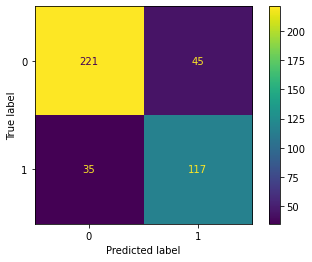

In [46]:
# Predict
from sklearn import metrics

y_pred = logr.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

metrics.plot_confusion_matrix(logr, X_test, y_test)
plt.show()

The logistic regression model has an accuracy of 0.8, thus we can predict correctly 8 out of 10 observations of the test dataset. The accuracy in predicting passengers who survived and those who didn't survive is very similar since the specificity is 0.83 (221/221+45) and the sensibility 0.77 (117/117+35).